In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor


/home/ebrown/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


In [3]:
model.vision_encoder.config

SamVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "global_attn_indexes": [
    2,
    5,
    8,
    11
  ],
  "hidden_act": "gelu",
  "hidden_size": 768,
  "image_size": 1024,
  "initializer_factor": 1.0,
  "initializer_range": 1e-10,
  "intermediate_size": 6144,
  "layer_norm_eps": 1e-06,
  "mlp_dim": 3072,
  "mlp_ratio": 4.0,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "num_pos_feats": 128,
  "output_channels": 256,
  "patch_size": 16,
  "projection_dim": 512,
  "qkv_bias": true,
  "transformers_version": "4.37.0",
  "use_abs_pos": true,
  "use_rel_pos": true,
  "window_size": 14
}

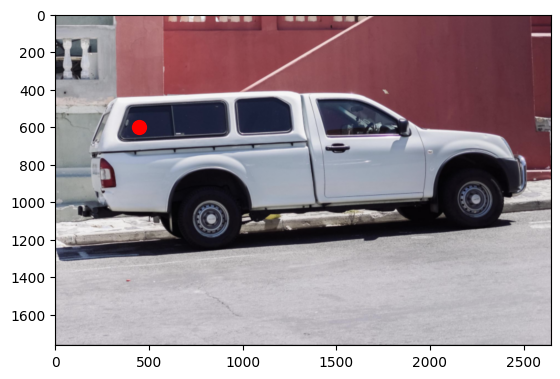

In [4]:

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]] # 2D localization of a window

# visualize the input image and the input points

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(raw_image)
for point in input_points[0]:
    ax.scatter(*point, c="red", s=100)
plt.show()

In [5]:
raw_image.size

(2646, 1764)

In [6]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt")
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores


# visualize the output masks

# fig, ax = plt.subplots()

In [7]:
inputs = processor(raw_image, return_tensors="pt")
inputs

{'pixel_values': tensor([[[[-0.5082, -0.4739, -0.4054,  ..., -0.4054, -0.4054, -0.4054],
          [-1.6727, -1.7069, -1.4158,  ..., -1.4843, -1.4843, -1.5014],
          [-1.2445, -1.3473, -0.5424,  ..., -0.7479, -0.7479, -0.7993],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.3901, -0.3550, -0.2850,  ..., -0.2850, -0.2850, -0.2850],
          [-1.5805, -1.5980, -1.2829,  ..., -1.6681, -1.6681, -1.6856],
          [-1.1429, -1.2479, -0.3550,  ..., -1.4580, -1.4580, -1.4755],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.1661, -0.1312, -0.0615,  ..., -0.0615, -0.0615, -0.0615],
          [-1

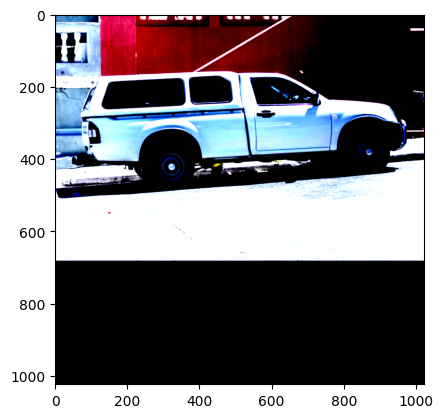

In [8]:
plt.imshow(inputs["pixel_values"][0].permute(1, 2, 0))

In [9]:
model.get_input_embeddings()

SamPatchEmbeddings(
  (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

In [10]:
embeddings = model.get_image_embeddings(inputs["pixel_values"])
embeddings.shape

torch.Size([1, 256, 64, 64])

In [11]:
out = model.vision_encoder(inputs["pixel_values"], output_hidden_states=True)
out.keys()

odict_keys(['last_hidden_state', 'hidden_states'])

In [12]:
for i in range(len(out["hidden_states"])):
    print(i, out["hidden_states"][i].shape)

0 torch.Size([1, 64, 64, 768])
1 torch.Size([1, 64, 64, 768])
2 torch.Size([1, 64, 64, 768])
3 torch.Size([1, 64, 64, 768])
4 torch.Size([1, 64, 64, 768])
5 torch.Size([1, 64, 64, 768])
6 torch.Size([1, 64, 64, 768])
7 torch.Size([1, 64, 64, 768])
8 torch.Size([1, 64, 64, 768])
9 torch.Size([1, 64, 64, 768])
10 torch.Size([1, 64, 64, 768])
11 torch.Size([1, 64, 64, 768])
12 torch.Size([1, 64, 64, 768])


In [13]:
x = out["last_hidden_state"]
x.permute(0, 3, 1, 2)

tensor([[[[-0.0089, -0.0030,  0.0044,  ...,  0.0319,  0.0329,  0.0166],
          [ 0.2382,  0.0941,  0.0932,  ..., -0.0883, -0.0876, -0.0146],
          [ 0.0250,  0.0249,  0.0298,  ...,  0.0274,  0.0272,  0.0182],
          ...,
          [-0.1195,  0.1114,  0.1540,  ..., -0.0420, -0.0469, -0.0611],
          [ 0.0997,  0.1184,  0.1288,  ..., -0.1652, -0.1621, -0.1331],
          [-0.0490, -0.0735, -0.0913,  ..., -0.0276, -0.0275,  0.0215]],

         [[-0.0073, -0.0042,  0.0046,  ...,  0.0198,  0.0212,  0.0066],
          [ 0.0029, -0.1060, -0.0862,  ..., -0.1107, -0.1128, -0.0480],
          [ 0.0358, -0.0112,  0.0158,  ...,  0.0417,  0.0415,  0.0343],
          ...,
          [-0.1347,  0.1715,  0.1648,  ..., -0.0449, -0.0469, -0.0466],
          [ 0.1034,  0.0673,  0.0650,  ..., -0.2149, -0.2142, -0.1884],
          [ 0.0151, -0.0006, -0.0094,  ..., -0.0219, -0.0215,  0.0137]],

         [[-0.0143, -0.0133, -0.0044,  ...,  0.0142,  0.0153,  0.0022],
          [ 0.0213, -0.0808, -

In [14]:
64 * 64

4096

In [15]:
image_size = model.vision_encoder.config.image_size
patch_size = model.vision_encoder.config.patch_size
num_patches_per_side = image_size // patch_size
num_patches = num_patches_per_side ** 2
print(f"Image size: {image_size}, Patch size: {patch_size}, Number of patches: {num_patches}, Number of patches per side: {num_patches_per_side}")

Image size: 1024, Patch size: 16, Number of patches: 4096, Number of patches per side: 64


In [16]:
model.vision_encoder.get_input_embeddings()(inputs["pixel_values"]).shape

torch.Size([1, 64, 64, 768])

In [17]:
embeddings.shape

torch.Size([1, 256, 64, 64])

In [18]:
model.config

SamConfig {
  "_name_or_path": "facebook/sam-vit-base",
  "architectures": [
    "SamModel"
  ],
  "initializer_range": 0.02,
  "mask_decoder_config": {
    "model_type": ""
  },
  "model_type": "sam",
  "prompt_encoder_config": {
    "model_type": ""
  },
  "torch_dtype": "float32",
  "transformers_version": "4.37.0",
  "vision_config": {
    "dropout": 0.0,
    "initializer_factor": 1.0,
    "intermediate_size": 6144,
    "model_type": "",
    "projection_dim": 512
  }
}

In [19]:
model.vision_encoder.config

SamVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "global_attn_indexes": [
    2,
    5,
    8,
    11
  ],
  "hidden_act": "gelu",
  "hidden_size": 768,
  "image_size": 1024,
  "initializer_factor": 1.0,
  "initializer_range": 1e-10,
  "intermediate_size": 6144,
  "layer_norm_eps": 1e-06,
  "mlp_dim": 3072,
  "mlp_ratio": 4.0,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "num_pos_feats": 128,
  "output_channels": 256,
  "patch_size": 16,
  "projection_dim": 512,
  "qkv_bias": true,
  "transformers_version": "4.37.0",
  "use_abs_pos": true,
  "use_rel_pos": true,
  "window_size": 14
}

In [20]:
model.vision_encoder.config.hidden_size

768

In [21]:
masks[0].shape

torch.Size([1, 3, 1764, 2646])

In [22]:
masks[0][0].reshape(masks[0][0]

SyntaxError: incomplete input (2443769290.py, line 1)

In [ ]:
masks[0][0].shape

torch.Size([3, 1764, 2646])

In [23]:
import torch
from open_clip import create_model_from_pretrained 

In [24]:
clip_model, processor = create_model_from_pretrained('hf-hub:laion/CLIP-convnext_large_d_320.laion2B-s29B-b131K-ft-soup')

In [31]:
vars(clip_model.visual.trunk)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('stem',
               Sequential(
                 (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
                 (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
               )),
              ('stages',
               Sequential(
                 (0): ConvNeXtStage(
                   (downsample): Identity()
                   (block

In [33]:
clip_model.visual.trunk.num_features

1536

In [35]:
vars(clip_model.visual)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('trunk',
               ConvNeXt(
                 (stem): Sequential(
                   (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
                   (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
                 )
                 (stages): Sequential(
                   (0): ConvNeXtStage(
                     (downsample): Ident

In [36]:
processor

Compose(
    Resize(size=320, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(320, 320))
    <function _convert_to_rgb at 0x7f9acc7e5c60>
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)

In [37]:
type(clip_model.visual.trunk)

timm.models.convnext.ConvNeXt